In [2]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

plaq = plaq12
L = plaq['L']
basis = spin_basis_1d(L, pauli=0)


ops = hmf.operators.mf_ops(plaq, basis)
maxit = 50

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Chiral observables

Let's define some observables. First, we can look at scalar chiralities. On some triangle in the lattice with sites 0, 1, and 2, this is
\begin{equation}
\chi_{012} = \vec\sigma_0 \cdot\left(\vec\sigma_1 \times \vec\sigma_2\right).
\end{equation}
We can also look at the helicity:
\begin{equation}
h_{012}^\alpha = \left(\vec\sigma_0 \times\vec \sigma_1 + \vec \sigma_1 \times \vec \sigma_2 + \vec \sigma_2 \times \vec \sigma_0\right)_\alpha
\end{equation}

In [3]:
urts = [[4,0,1],
        [5,1,2],
        [7,3,4],
        [8,4,5],
        [9,5,6],
        [10,7,8],
        [11,8,9]]

dwts = [[0,3,4],
        [1,4,5],
        [2,5,6],
        [4,7,8],
        [5,8,9],
        [8,10,11]]

def scalar_chirality(sites, basis):
    # a.(bxc)
    a, b, c = sites
    op_lst = [['xyz', [[1, a, b, c]]], 
              ['xzy', [[-1, a, b, c]]],
              ['yzx', [[1, a, b, c]]], 
              ['yxz', [[-1, a, b, c]]],
              ['zxy', [[1, a, b, c]]], 
              ['zyx', [[-1, a, b, c]]],
             ]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)

def z_helicity(sites, basis):
    # (a x b + b x c + c x a)_z
    a, b, c = sites
    op_lst = [['xy', [[1, a, b], [1, b, c], [1, c, a]]], 
              ['yx', [[-1, a, b], [-1, b, c], [-1, c, a]]]
             ]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)


urt_ops = [scalar_chirality(sites, basis) for sites in urts]
dwt_ops = [scalar_chirality(sites, basis) for sites in dwts]

urt_hel = [z_helicity(sites, basis) for sites in urts]
dwt_hel = [z_helicity(sites, basis) for sites in dwts]


def get_chis(v):
    urt_chis = np.zeros(7)
    urt_chis2 = np.zeros(7)
    for i in range(7):
        urt_chis[i] = np.real(urt_ops[i].expt_value(v))
        # if i != 6:
        #     dwt_chis[i] = np.real(dwt_ops[i].expt_value(v))
        urt_chis2[i] = np.real(urt_ops[i].matrix_ele(v, urt_ops[i].dot(v)))
    return urt_chis, urt_chis2

def get_hels(v):
    urt_hels = np.zeros(7)
    urt_hels2 = np.zeros(7)
    for i in range(7):
        urt_hels[i] = np.real(urt_hel[i].expt_value(v))
        urt_hels2[i] = np.real(urt_hel[i].matrix_ele(v, urt_hel[i].dot(v)))
    return urt_hels, urt_hels2

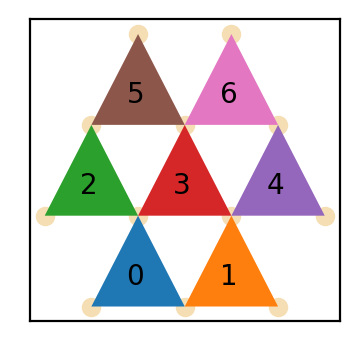

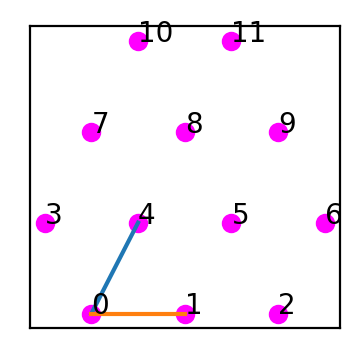

In [4]:
a1 = np.array((1, 0))
a2 = np.array((-0.5, 0.5*np.sqrt(3)))
a0 = np.array((0.5, 0.5*np.sqrt(3)))

b1 = 2*np.pi*np.array((1, -1/np.sqrt(3)))
b2 = 4*np.pi*np.array((0, 1/np.sqrt(3)))

M = np.pi*np.array((1, 1/np.sqrt(3)))
K = np.pi*np.array((4/3, 0))

plt.figure(figsize=(2,2), dpi=200)
rs = [(0,0), a1, 2*a1,
      a2, a2+a1, a2+2*a1, a2+3*a1,
      2*a2+a1, 2*a2+2*a1, 2*a2+3*a1,
      3*a2+2*a1, 3*a2+3*a1]
rx = [r[0] for r in rs]
ry = [r[1] for r in rs]
plt.scatter(rx, ry, color='wheat')
# for i, r in enumerate(rs):
#     plt.text(r[0], r[1], i)
# plt.plot([0, a0[0]], [0, a0[1]])
# plt.plot([0, a1[0]], [0, a1[1]])
plt.xticks([])
plt.yticks([])


urt_inds = [0, 1, 3, 4, 5, 7, 8]
urt_rs = [None for i in range(len(urt_inds))]
for i, u in enumerate(urt_inds):
    urt_rs[i] = rs[u] + .25*a0 + .25 * a1
    plt.text(*urt_rs[i], i, color='black')
    inds = urts[i]
    plt.fill([rx[ind] for ind in inds], [ry[ind] for ind in inds])
plt.show()




# Nematic observables

One more thing to look at is correlators of the form $\sigma_i \dot \sigma_j$. Let's define the nematic observable
\begin{equation}
\mathcal N_{01} = \vec \sigma_0 \cdot \vec \sigma_1.
\end{equation}
Given that our model has interactions of this form along nearest and next-nearest, it will probably be useful to measure this in both cases. WLOG (hopefully), let's look at bonds all parallel in one direction. I will choose horizontal for nearest and next-next nearest, and vertical for next-nearest.

In [32]:
nbonds = [[0,1], [1,2], [3,4], [4,5], [5,6], [7,8], [8,9], [10,11]]
nnbonds = [[0,7], [1,8], [2,9], [4,10], [5,11]]
nnnbonds = [[0,2], [3,5], [4,6], [7,9]]

def nem(sites, basis):
    # a.b
    a, b = sites
    op_lst = [['xx', [[1, a, b]]], 
              ['yy', [[1, a, b]]],
              ['zz', [[1, a, b]]]]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)




n_ops = [nem(sites, basis) for sites in nbonds]
nn_ops = [nem(sites, basis) for sites in nnbonds]
nnn_ops = [nem(sites, basis) for sites in nnnbonds]

def get_nems(v):
    n_nems = np.zeros(8)
    nn_nems = np.zeros(5)
    nnn_nems = np.zeros(4)
    for i in range(8):
        n_nems[i] = np.real(n_ops[i].expt_value(v))
    for i in range(5):
        nn_nems[i] = np.real(nn_ops[i].expt_value(v))
    for i in range(4):
        nnn_nems[i] = np.real(nnn_ops[i].expt_value(v))
    return n_nems, nn_nems, nnn_nems

# Singlet observable
It's important to note that all external fields are zero in the HMFT solution of the intermediate phase. This implies some similarities with the square-lattice case. In that case, the zero mean-field values are due to a plaquette crystal ground state. We could imagine a similar situation in the triangular lattice. The bonds plotted below are one of a family of singlet configurations within the 12-site plaquette (which seems to be the minimal one to capture the 0 mean-field results). This configuration has a $C_3$ rotational symmetry, which may be important

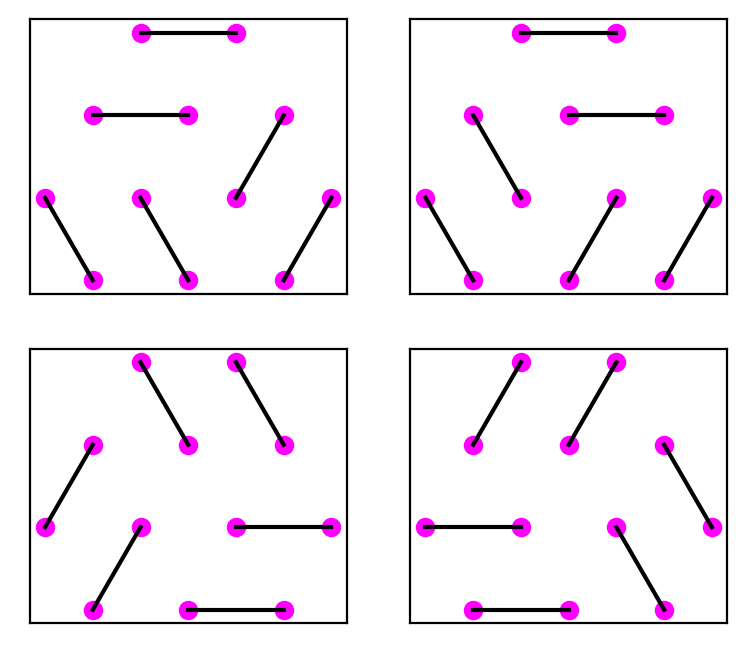

In [27]:
singlet_bonds = [[[0,3], [1,4], [2,6], [5,9], [7,8], [10,11]],
                 [[0,3], [4,7], [2,6], [1,5], [8,9], [10,11]],
                 [[0,4], [3,7], [10,8], [11,9], [5,6], [1,2]],
                 [[0,1], [3,4], [7,10], [8,11], [9,6], [5,2]]]

plt.figure(figsize=(4.5,4), dpi=200)
for j in range(4):
    plt.subplot(2,2,j+1)
    plt.scatter(rx, ry, color='magenta')
    for i, sb in enumerate(singlet_bonds[j]):
        plt.plot([rx[sb[0]], rx[sb[1]]], [ry[sb[0]], ry[sb[1]]], color = 'black')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [38]:
singlet_ops = [None for i in range(4)]
for i in range(4):
    singlet_ops[i] = quantum_operator({'static': [['xx', [[1, sb[0], sb[1]] for sb in singlet_bonds[i]]],
                                          ['yy', [[1, sb[0], sb[1]] for sb in singlet_bonds[i]]],
                                          ['zz', [[1, sb[0], sb[1]] for sb in singlet_bonds[i]]]
                                         ]}, basis=basis)

def get_singlets(v):
    singlets = np.array([sop.expt_value(v) for sop in singlet_ops])
    return singlets

def get_squared_singlets(v):
    singlets = np.array([sop.matrix_ele(v, sop.dot(v)) for sop in singlet_ops])
    return singlets

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


# Low $J_2$ phase

In [39]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .01, 'yy': .01, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

urt_mid, urt_mid2 = get_chis(v)
print('Upright triangle chiralities')
print(urt_mid)
print('Squared')
print(urt_mid2)

urt_h, urt_h2 = get_hels(v)
print('Upright triangle helicities')
print(urt_h)
print('Squared')
print(urt_h2)

n_nems, nn_nems, nnn_nems = get_nems(v)
print('Nearest-neighbor nematicites')
print(n_nems)
print('Next-nearest:')
print(nn_nems)
print('Next-next-nearest:')
print(nnn_nems)

singlets = get_singlets(v)
print('Singlet order parameters:')
print(singlets)

sq_singlets = get_squared_singlets(v)
print('Squred:')
print(sq_singlets)

Energy: -4.3579779498266165
Converged? True
Upright triangle chiralities
[-1.91513472e-15 -6.07153217e-14 -2.42167397e-14 -6.89225153e-14
  1.36991113e-14  7.24247051e-16  1.32394096e-14]
Squared
[0.16135513 0.16134331 0.16172519 0.17118009 0.16179853 0.16434809
 0.16432441]
Upright triangle helicities
[-0.4338898  -0.43343034 -0.52348714 -0.57506423 -0.52296202 -0.56128188
 -0.56116023]
Squared
[0.64542053 0.64537324 0.64690076 0.68472038 0.64719412 0.65739236
 0.65729763]
Nearest-neighbor nematicites
[-0.35385284 -0.3534212  -0.0996426  -0.26827953 -0.09979757 -0.19250933
 -0.19318365 -0.34722049]
Next-nearest:
[0.17492257 0.17877567 0.17480012 0.19306369 0.19304507]
Next-next-nearest:
[ 0.12187012 -0.09343973 -0.09321942 -0.08801659]
Singlet order parameters:
[-1.76052467-1.38777878e-17j -1.76158286-4.16333634e-17j
 -1.08356771-1.38777878e-17j -1.08515021+4.85722573e-17j]
Squred:
[4.61970889-2.77555756e-16j 4.62349293+2.22044605e-16j
 3.38448876+1.66533454e-16j 3.38829759+3.05311332

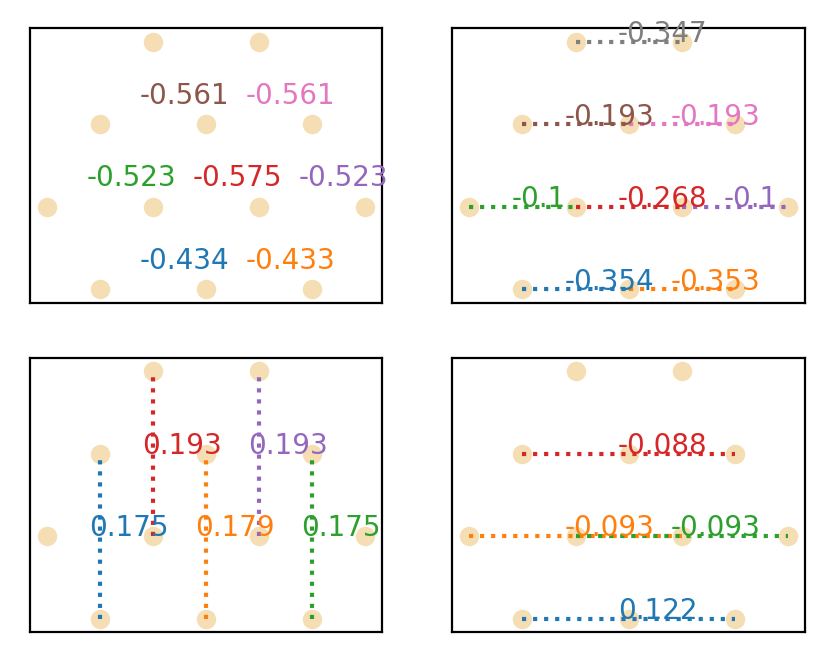

In [6]:
n_rs = [None for i in range(8)]
nn_rs = [None for i in range(5)]
nnn_rs = [None for i in range(4)]


plt.figure(figsize=(5,4), dpi=200)
plt.subplot(2,2,1)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, ur in enumerate(urt_rs):
    # plt.scatter(*ur, color='gray')
    plt.text(*ur, np.round(urt_h[i], 3), color=colors[i])
    
plt.subplot(2,2,2)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nbonds):
    n_rs[i] = rs[u[0]] + .5 * a1 + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(n_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.subplot(2,2,3)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nnbonds):
    n_rs[i] = rs[u[0]] + .5*(a2 + a0) + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(nn_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.subplot(2,2,4)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nnnbonds):
    n_rs[i] = rs[u[0]] + a1 + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(nnn_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.show()

# Disordered phase

In [40]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .18, 'yy': .18, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

urt_mid, urt_mid2 = get_chis(v)
print('Upright triangle chiralities')
print(urt_mid)
print('Squared')
print(urt_mid2)

urt_h, urt_h2 = get_hels(v)
print('Upright triangle helicities')
print(urt_h)
print('Squared')
print(urt_h2)

n_nems, nn_nems, nnn_nems = get_nems(v)
print('Nearest-neighbor nematicites')
print(n_nems)
print('Next-nearest:')
print(nn_nems)
print('Next-next-nearest:')
print(nnn_nems)

singlets = get_singlets(v)
print('Singlet order parameters:')
print(singlets)

sq_singlets = get_squared_singlets(v)
print('Squred:')
print(sq_singlets)

Energy: -3.7481888823324234
Converged? True
Upright triangle chiralities
[ 6.74887772e-13 -5.11679686e-13  3.07460117e-13 -1.35723424e-13
 -3.88775335e-14 -1.09834537e-12  4.47044311e-13]
Squared
[0.16954767 0.16954767 0.16954767 0.16964813 0.16954767 0.16954767
 0.16954767]
Upright triangle helicities
[ 1.66529290e-12 -1.14573116e-12 -3.63640155e-13  1.93808623e-12
  2.30227316e-12  2.66705061e-12 -8.98586761e-16]
Squared
[0.67819069 0.67819069 0.67819069 0.67859254 0.67819069 0.67819069
 0.67819069]
Nearest-neighbor nematicites
[-0.31791457 -0.31791458 -0.08928254 -0.20239503 -0.08928255 -0.19918425
 -0.19918426 -0.48133532]
Next-nearest:
[0.14228111 0.08971833 0.1422811  0.08190727 0.08190727]
Next-next-nearest:
[ 0.07427599 -0.00497209 -0.00497209 -0.00582196]
Singlet order parameters:
[-2.04155872+5.55111512e-17j -2.04155874-2.77555756e-16j
 -1.22159137+0.00000000e+00j -1.22159134+2.22044605e-16j]
Squred:
[5.64430815+4.44089210e-16j 5.64430822-6.66133815e-16j
 4.75615178+2.2204460

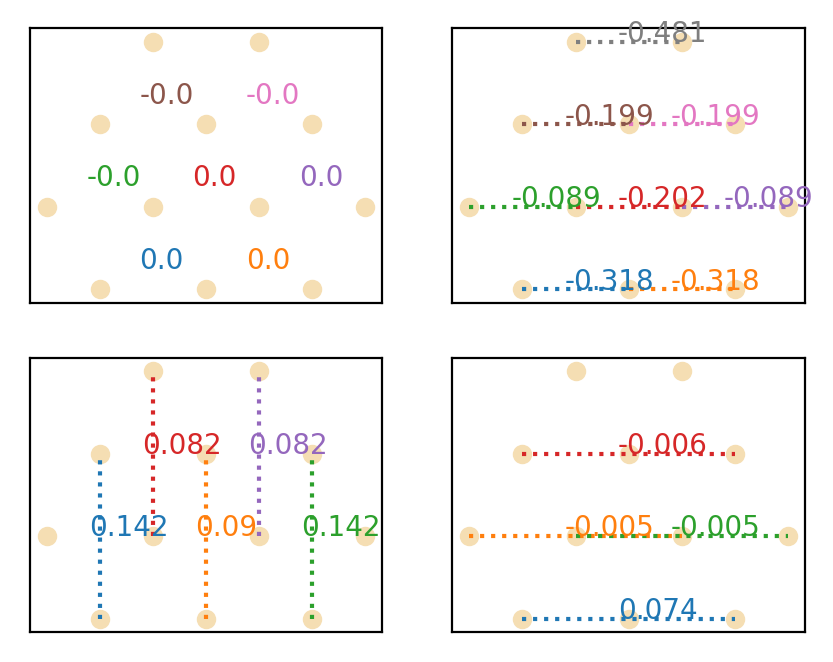

In [8]:
plt.figure(figsize=(5,4), dpi=200)
plt.subplot(2,2,1)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, ur in enumerate(urt_rs):
    # plt.scatter(*ur, color='gray')
    plt.text(*ur, np.round(urt_h[i], 3), color=colors[i])
    
plt.subplot(2,2,2)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nbonds):
    n_rs[i] = rs[u[0]] + .5 * a1 + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(n_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.subplot(2,2,3)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nnbonds):
    n_rs[i] = rs[u[0]] + .5*(a2 + a0) + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(nn_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.subplot(2,2,4)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nnnbonds):
    n_rs[i] = rs[u[0]] + a1 + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(nnn_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.show()

# Stripy phase

In [41]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .31, 'yy': .31, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

urt_mid, urt_mid2 = get_chis(v)
print('Upright triangle chiralities')
print(urt_mid)
print('Squared')
print(urt_mid2)

urt_h, urt_h2 = get_hels(v)
print('Upright triangle helicities')
print(urt_h)
print('Squared')
print(urt_h2)

n_nems, nn_nems, nnn_nems = get_nems(v)
print('Nearest-neighbor nematicites')
print(n_nems)
print('Next-nearest:')
print(nn_nems)
print('Next-next-nearest:')
print(nnn_nems)

singlets = get_singlets(v)
print('Singlet order parameters:')
print(singlets)

sq_singlets = get_squared_singlets(v)
print('Squred:')
print(sq_singlets)

Energy: -4.25068210926876
Converged? True
Upright triangle chiralities
[-1.67590410e-12 -2.84324838e-12 -1.01739476e-12 -3.67979544e-13
  4.36667319e-13 -8.13172880e-13  4.31469097e-15]
Squared
[0.14653715 0.17036657 0.15499262 0.14625096 0.16397787 0.1502328
 0.1445442 ]
Upright triangle helicities
[ 5.68921519e-06  8.44754244e-07  7.50348368e-06 -4.30966317e-06
  3.33876585e-06 -2.03169233e-06  6.51151464e-06]
Squared
[0.5861486  0.68146628 0.61997047 0.58500383 0.6559115  0.6009312
 0.57817679]
Nearest-neighbor nematicites
[-0.32556366 -0.48992429 -0.29290159 -0.32883346 -0.34984841 -0.3436186
 -0.30002611 -0.3856341 ]
Next-nearest:
[-0.12697294 -0.17760963 -0.15183297 -0.19571629 -0.20298397]
Next-next-nearest:
[0.19693375 0.17906067 0.19480727 0.2064273 ]
Singlet order parameters:
[-1.1824166 -3.46944695e-17j -1.2165823 -6.93889390e-18j
 -1.1485597 +2.77555756e-17j -0.92033652-9.02056208e-17j]
Squred:
[2.50114477+5.55111512e-17j 2.6298654 -1.38777878e-17j
 2.63472794+6.93889390e-1

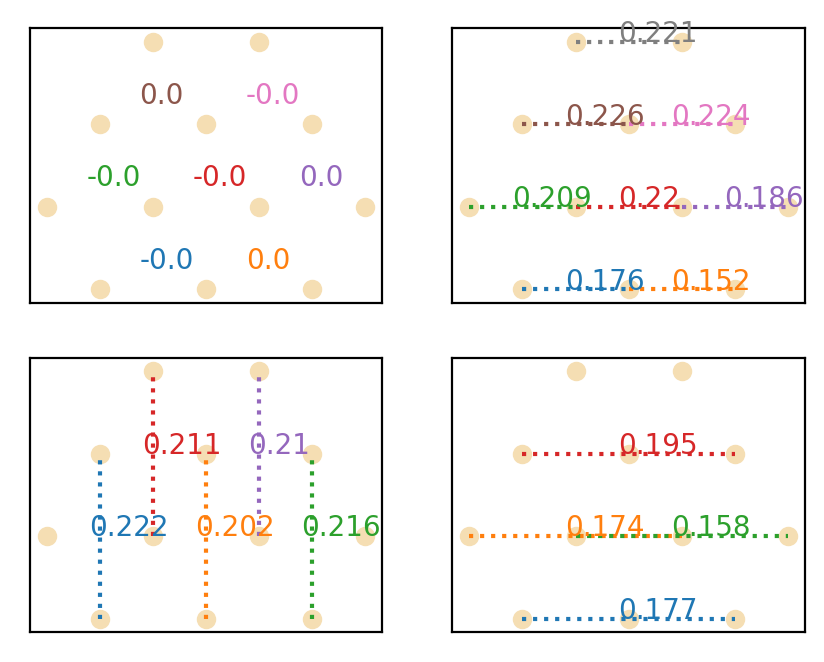

In [10]:
plt.figure(figsize=(5,4), dpi=200)
plt.subplot(2,2,1)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, ur in enumerate(urt_rs):
    # plt.scatter(*ur, color='gray')
    plt.text(*ur, np.round(urt_h[i], 3), color=colors[i])
    
plt.subplot(2,2,2)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nbonds):
    n_rs[i] = rs[u[0]] + .5 * a1 + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(n_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.subplot(2,2,3)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nnbonds):
    n_rs[i] = rs[u[0]] + .5*(a2 + a0) + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(nn_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.subplot(2,2,4)
plt.scatter(rx, ry, color='wheat')
plt.xticks([])
plt.yticks([])
for i, u in enumerate(nnnbonds):
    n_rs[i] = rs[u[0]] + a1 + np.array((-.1, 0))
    plt.text(*n_rs[i], np.round(nnn_nems[i], 3), color=colors[i])
    r0 = rs[u[0]]
    r1 = rs[u[1]]
    plt.plot([r0[0], r1[0]], [r0[1], r1[1]], ls=':')
    
plt.show()